## Load Data

In [2]:
from scripts.preprocess_data import *
# Load, clean and normalize the df
df = load_data("dataset.json")
df = clean_data(df)
df = normalize_data(df)


In [3]:
import pandas as pd

relations = pd.read_csv("graph.csv")

## Build Graph and Compute Neigbhors

In [4]:
import networkx as nx

# Build graph
G = nx.from_pandas_edgelist(relations, source='source', target='target')

# Precompute neighbors
neighbors = {node: set(G.neighbors(node)) for node in G.nodes}

## Co-citation

In [126]:
import matplotlib.pyplot as plt

# Co-Citation Optimization
co_citation = {node: {n: len(neighbors[node] & neighbors[n]) for n in neighbors[node]} for node in G.nodes}


# Filter for high co-citation values
threshold = 1
subgraph_edges = [
    (node, target, weight) for node, connections in co_citation.items()
    for target, weight in connections.items() if weight >= threshold
]

# Create a subgraph
H = nx.Graph()
H.add_weighted_edges_from(subgraph_edges)

# Visualize subgraph

edge_labels = nx.get_edge_attributes(H, 'weight')
pos = nx.spring_layout(H)


KeyboardInterrupt: 

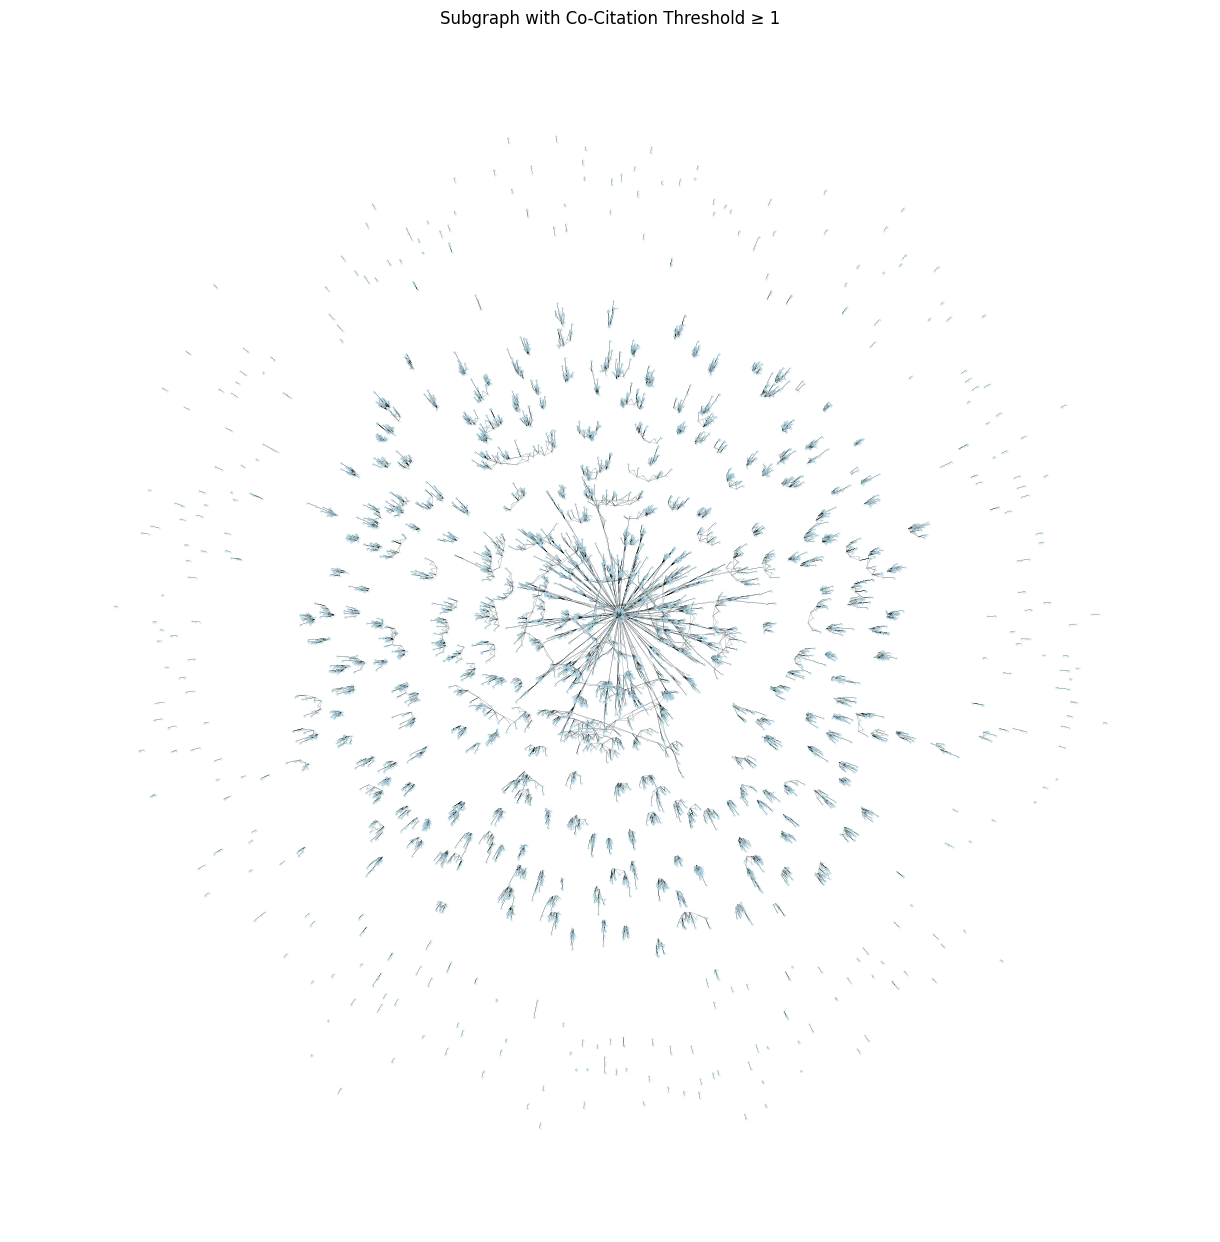

In [110]:

plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=False, node_size=0.1, width=0.1,node_color='lightblue')
plt.title(f"Subgraph with Co-Citation Threshold ≥ {threshold}")
plt.show()

In [150]:
import pandas as pd

# Determine the maximum co-citation value
max_co_citation = max(
    weight for connections in co_citation.values()
    for weight in connections.values()
)

# Create a summary table for the number of edges at each threshold, including threshold 0
threshold_summary = []
for threshold in range(0, max_co_citation + 2):
    filtered_edges = [
        (node, target, weight) for node, connections in co_citation.items()
        for target, weight in connections.items() if weight >= threshold
    ]
    # Count unique nodes in the filtered edges
    unique_nodes = set(node for edge in filtered_edges for node in edge[:2])
    threshold_summary.append({
        "Threshold": threshold,
        "Number of Edges": len(filtered_edges),
        "Number of Nodes": len(unique_nodes),
    })

# Convert to a DataFrame for tabular display
df_summary = pd.DataFrame(threshold_summary)

# Display the table
print(df_summary)

    Threshold  Number of Edges  Number of Nodes
0           0           189768            46849
1           1            46700            13776
2           2             7980             3894
3           3             2822             1718
4           4             1138              848
5           5              548              466
6           6              280              257
7           7              120              115
8           8               52               50
9           9               30               29
10         10                6                6
11         11                4                4
12         12                2                2
13         13                0                0


## Bibliographic Coupling

In [156]:
import networkx as nx
import matplotlib.pyplot as plt

bibliographic_coupling = {node: {n: len(set(G.neighbors(node)) & set(G.neighbors(n))) for n in G.neighbors(node)} for node in G.nodes}

threshold = 1

# Filter bibliographic coupling based on the threshold
filtered_bibliographic_coupling = {
    node: {n: count for n, count in couplings.items() if count >= threshold}
    for node, couplings in bibliographic_coupling.items()
}

# Create an undirected graph
UG = nx.Graph()

# Add nodes and edges with filtered coupling values
for node, couplings in filtered_bibliographic_coupling.items():
    for n, weight in couplings.items():
        UG.add_edge(node, n, weight=weight)

# Visualization
pos = nx.spring_layout(UG)


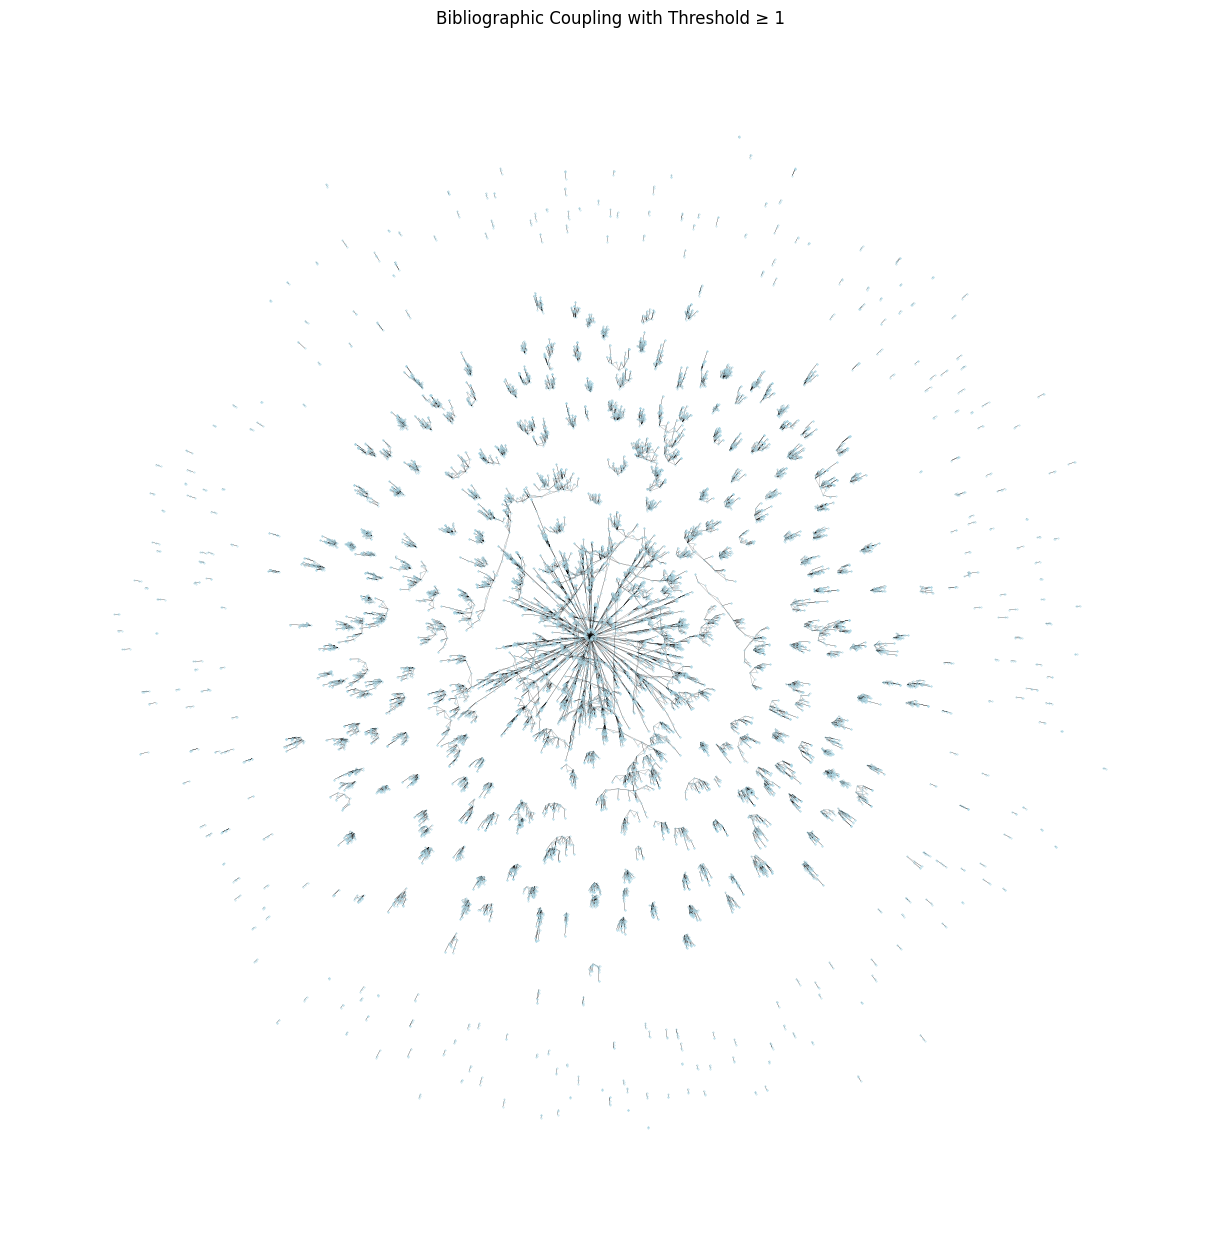

In [157]:
plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=False, node_size=0.1, width=0.1,node_color='lightblue')
plt.title(f"Bibliographic Coupling with Threshold ≥ {threshold}")
plt.show()

In [158]:
import networkx as nx
import pandas as pd

max_threshold = 12

# Create an empty dictionary to store nodes and edges count
results = {}

# Iterate over thresholds from 1 to max_threshold
for threshold in range(1, max_threshold + 2):
    filtered_bibliographic_coupling = {
        node: {n: count for n, count in couplings.items() if count >= threshold}
        for node, couplings in bibliographic_coupling.items()
    }

    # Create an undirected graph for each threshold
    UG = nx.Graph()

    # Add nodes and edges with filtered coupling values
    for node, couplings in filtered_bibliographic_coupling.items():
        for n, weight in couplings.items():
            UG.add_edge(node, n, weight=weight)

    # Get the number of nodes and edges
    num_nodes = UG.number_of_nodes()
    num_edges = UG.number_of_edges()

    # Store results in a dictionary
    results[threshold] = (num_nodes, num_edges)

# Convert the results to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Number of Nodes', 'Number of Edges'])

# Print the DataFrame as a table
print(df_results)


    Number of Nodes  Number of Edges
1             13776            23350
2              3894             3990
3              1718             1411
4               848              569
5               466              274
6               257              140
7               115               60
8                50               26
9                29               15
10                6                3
11                4                2
12                2                1
13                0                0


## Cycles & Acyclic Networks

In [10]:
cycles = list(nx.simple_cycles(G)) # Takes too long
print("Cycles:", cycles)

Acyclic: False


KeyboardInterrupt: 

## Hypergraphs

In [73]:
import hypernetx as hnx
import matplotlib.pyplot as plt

hyper_edges = relations.groupby('source')['target'].apply(list).to_dict()

# Create the initial hypergraph
H = hnx.Hypergraph(hyper_edges)

# Filter nodes with degree greater than a threshold
threshold = 4
filtered_edges = {node: edges for node, edges in hyper_edges.items() if node in H.nodes and H.degree(node) >= threshold}

# Create a new Hypergraph with the filtered nodes and edges
subset_H = hnx.Hypergraph(filtered_edges)

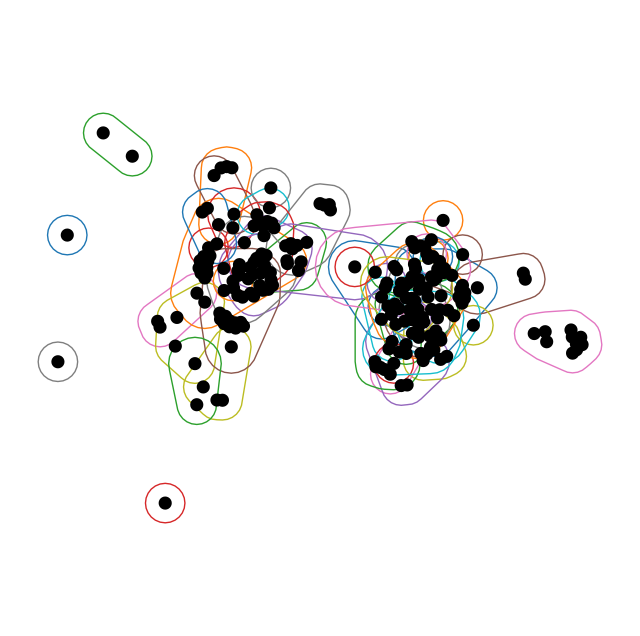

In [79]:
hnx.draw(subset_H,with_node_labels=False, with_edge_labels=False)

plt.show()

In [75]:
# Function to calculate the number of nodes and edges for a given threshold
def get_elements_for_threshold(threshold):
    # Ensure the nodes exist in the hypergraph
    filtered_edges = {node: edges for node, edges in hyper_edges.items() if node in H.nodes and H.degree(node) > threshold}
    subset_H = hnx.Hypergraph(filtered_edges)
    num_nodes = len(subset_H.nodes)
    num_edges = len(subset_H.edges)
    return num_nodes, num_edges

# Output the results for different thresholds
print(f"Threshold | Number of Nodes | Number of Hyperedges")
print("-" * 40)

for threshold in range(8):
    num_nodes, num_edges = get_elements_for_threshold(threshold)
    print(f"{threshold:8} | {num_nodes:14} | {num_edges:12}")

Threshold | Number of Nodes | Number of Hyperedges
----------------------------------------
       0 |          45827 |        24666
       1 |          44118 |        23983
       2 |            890 |          315
       3 |            209 |           54
       4 |            117 |           23
       5 |             39 |            8
       6 |             30 |            3
       7 |              0 |            0


## Degree and Density

In [5]:
degree = dict(G.degree())
density = nx.density(G)
#print(degree)
#print(density)

# Base Calculation for Measures

In [7]:
import networkx as nx
sample_size = 6000 # maybe later all
G_sampled = G.subgraph(list(G.nodes())[:sample_size])
pos = nx.spring_layout(G_sampled)  # positions for all nodes

## Centrality Measures

In [8]:
degree_centrality = nx.degree_centrality(G_sampled)
#print("Degree Centrality:", degree_centrality)

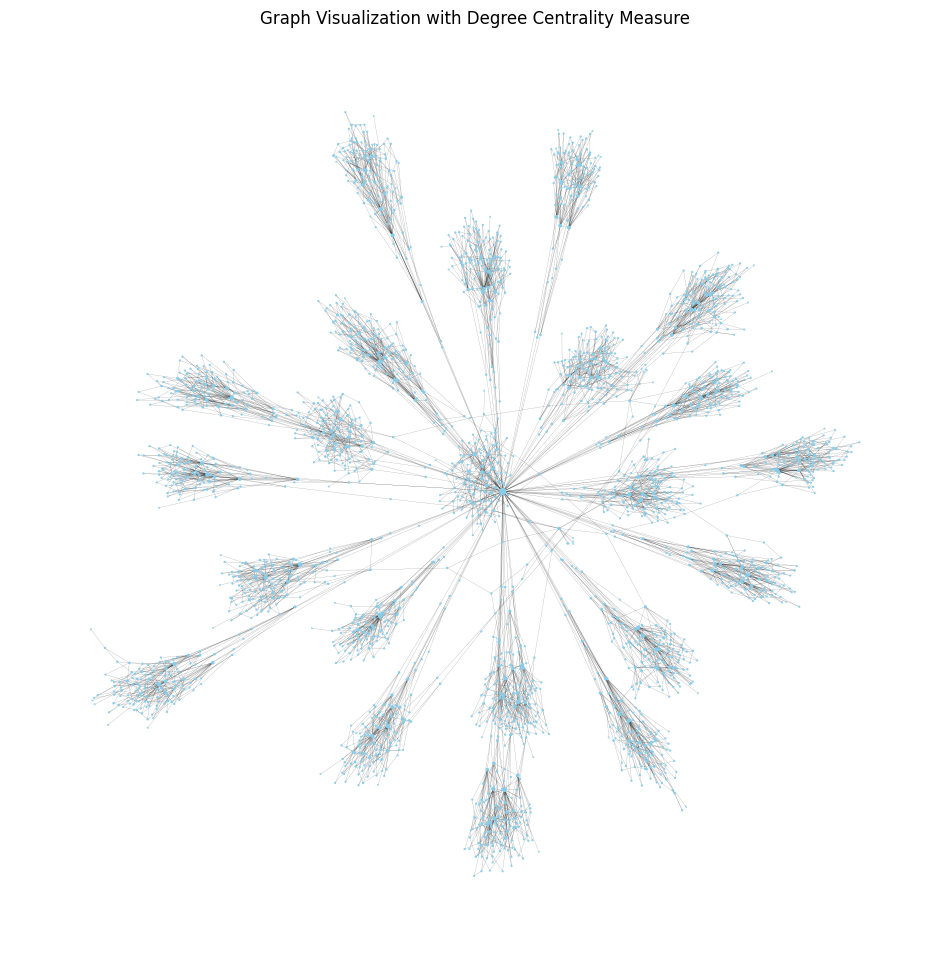

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in degree_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with Degree Centrality Measure")

# Display
plt.axis('off')
plt.show()

In [9]:
eigenvector_centrality = nx.eigenvector_centrality(G_sampled, max_iter=200)
#print("Eigenvector Centrality:", eigenvector_centrality)

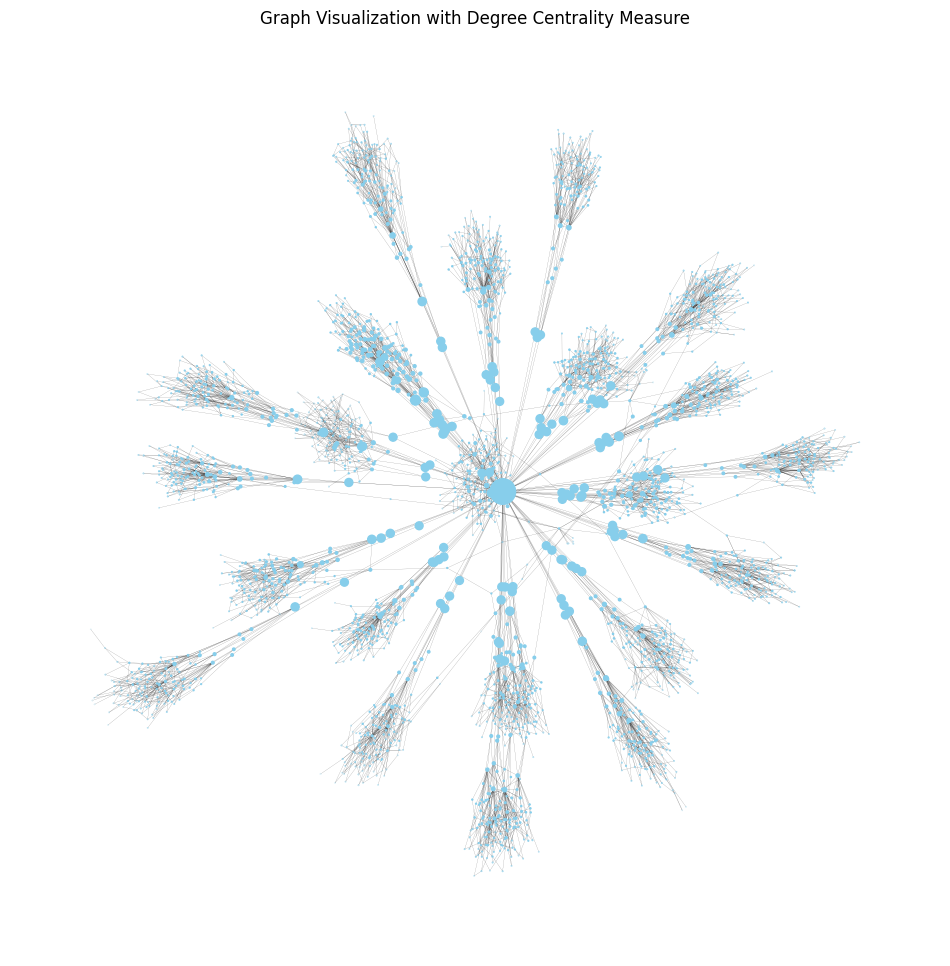

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in eigenvector_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with Eigenvector Centrality Measure")

# Display
plt.axis('off')
plt.show()

In [10]:
# katz_centrality = nx.katz_centrality(G, alpha=0.5, beta=1.0, max_iter=4000) # Takes too long
pagerank = nx.pagerank(G_sampled)
#print("Katz Centrality:", katz_centrality)
#print("PageRank:", pagerank)


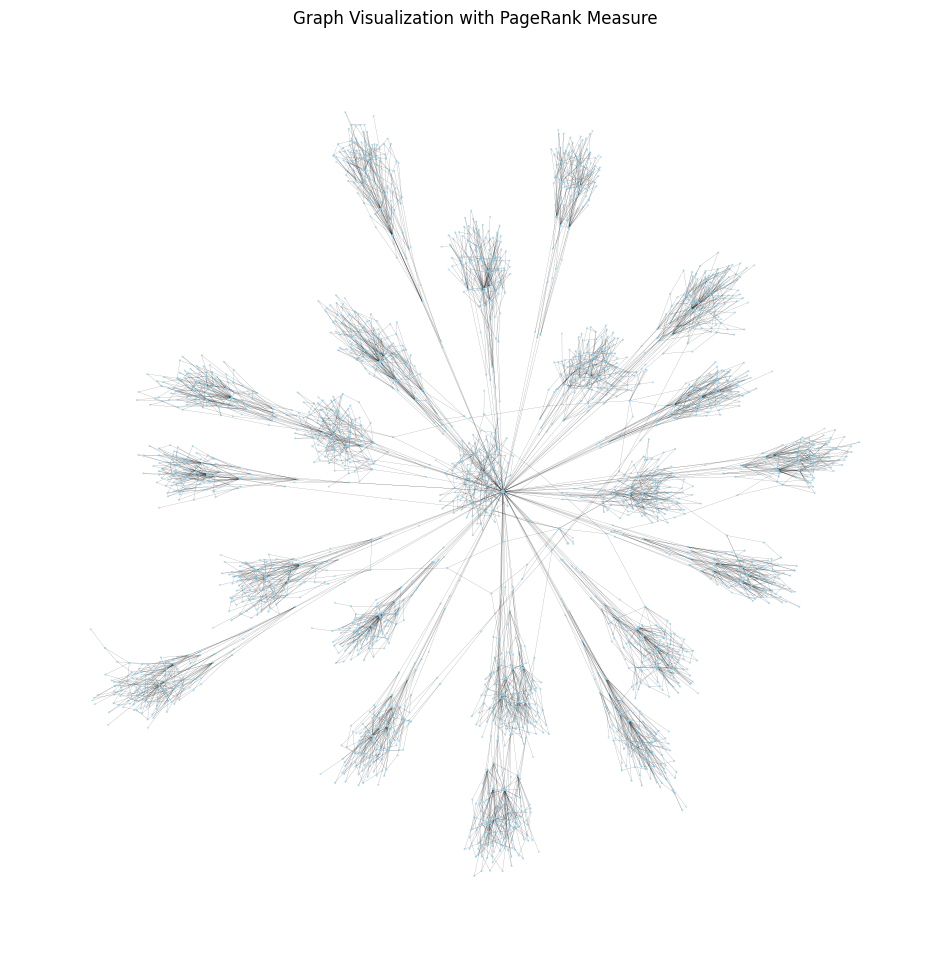

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 500 for v in pagerank.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

In [11]:
closeness_centrality = nx.closeness_centrality(G_sampled)
#print("Closeness Centrality:", closeness_centrality)

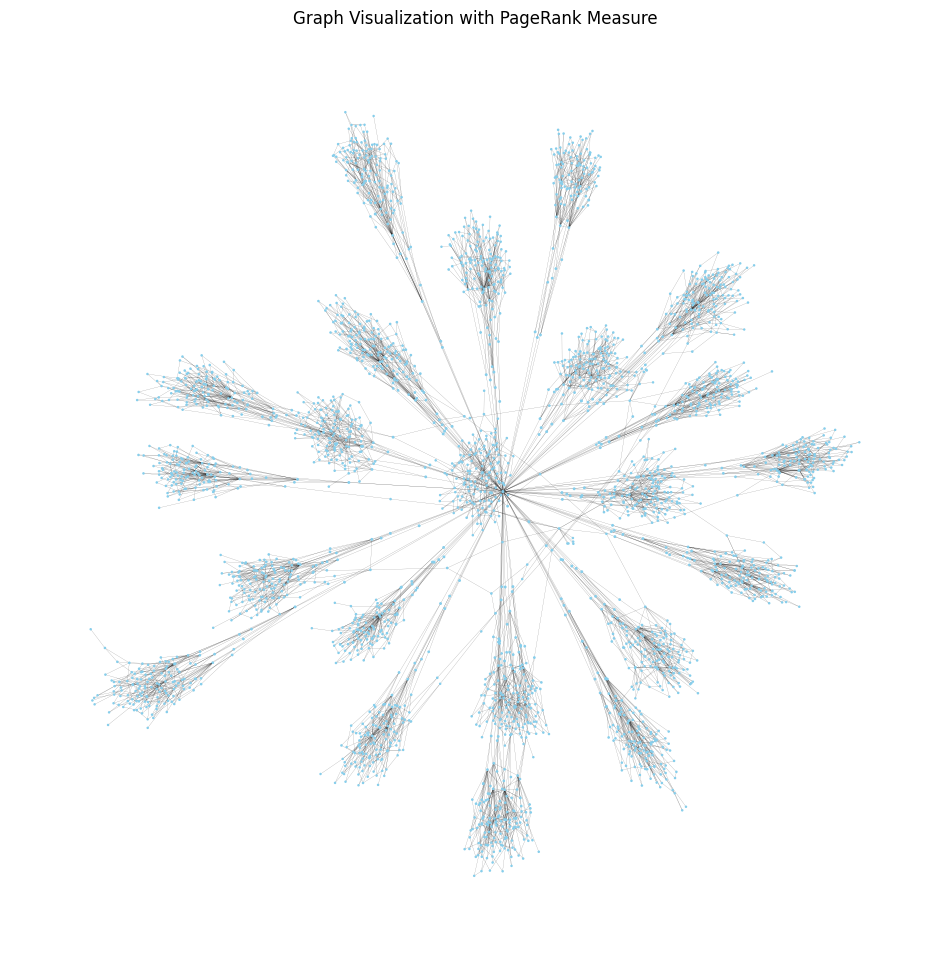

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 5 for v in closeness_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

In [12]:
betweenness_centrality = nx.betweenness_centrality(G_sampled) # takes really long
#print("Betweenness Centrality:", betweenness_centrality)

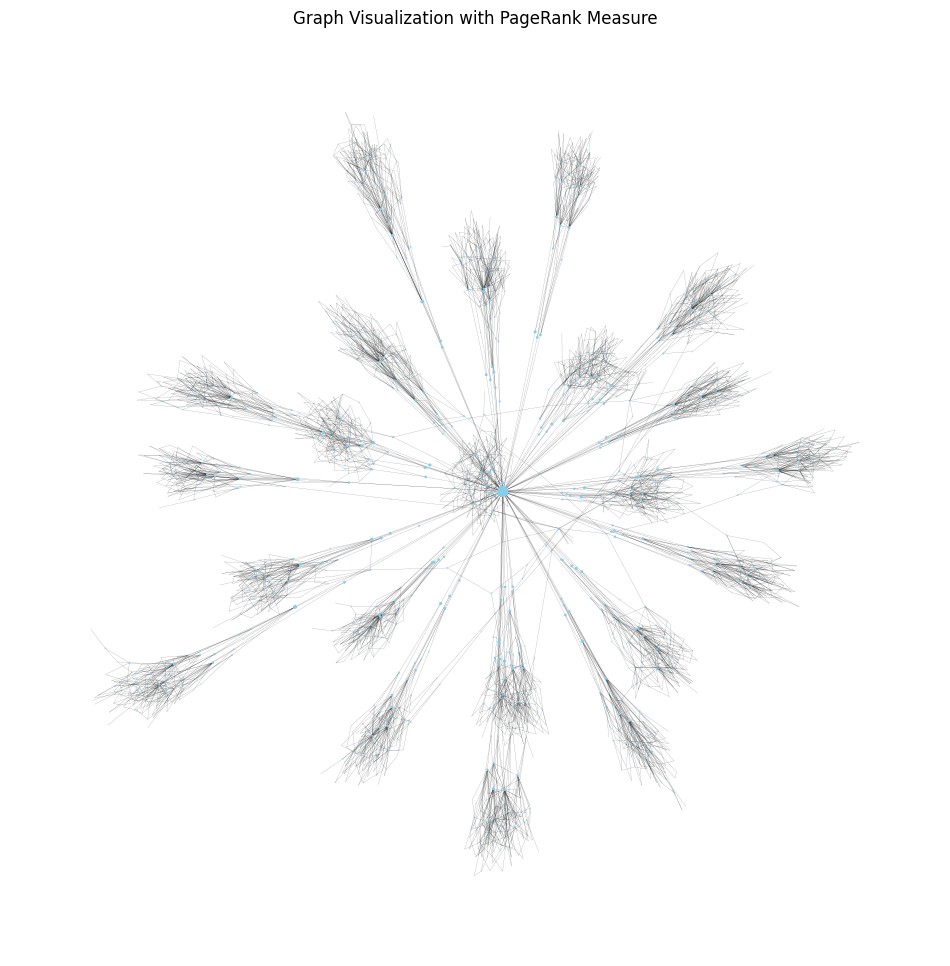

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# Draw the graph nodes with degree size scaling
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 50 for v in betweenness_centrality.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Visualization

# Add title
plt.title(f"Graph Visualization with PageRank Measure")

# Display
plt.axis('off')
plt.show()

### Structural Holes (Trash?)

In [13]:
def structural_holes(G):
    holes = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        internal_connections = len(neighbors)
        external_connections = len(set(G.nodes()) - neighbors)
        holes[node] = external_connections - internal_connections
    return holes

# Apply functions
holes = structural_holes(G_sampled)

#print("Structural Holes:", holes)

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph and `holes` is the structural holes dictionary
holes_values = list(holes.values())

# Create mappable for colorbar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=plt.Normalize(vmin=min(holes_values), vmax=max(holes_values)))

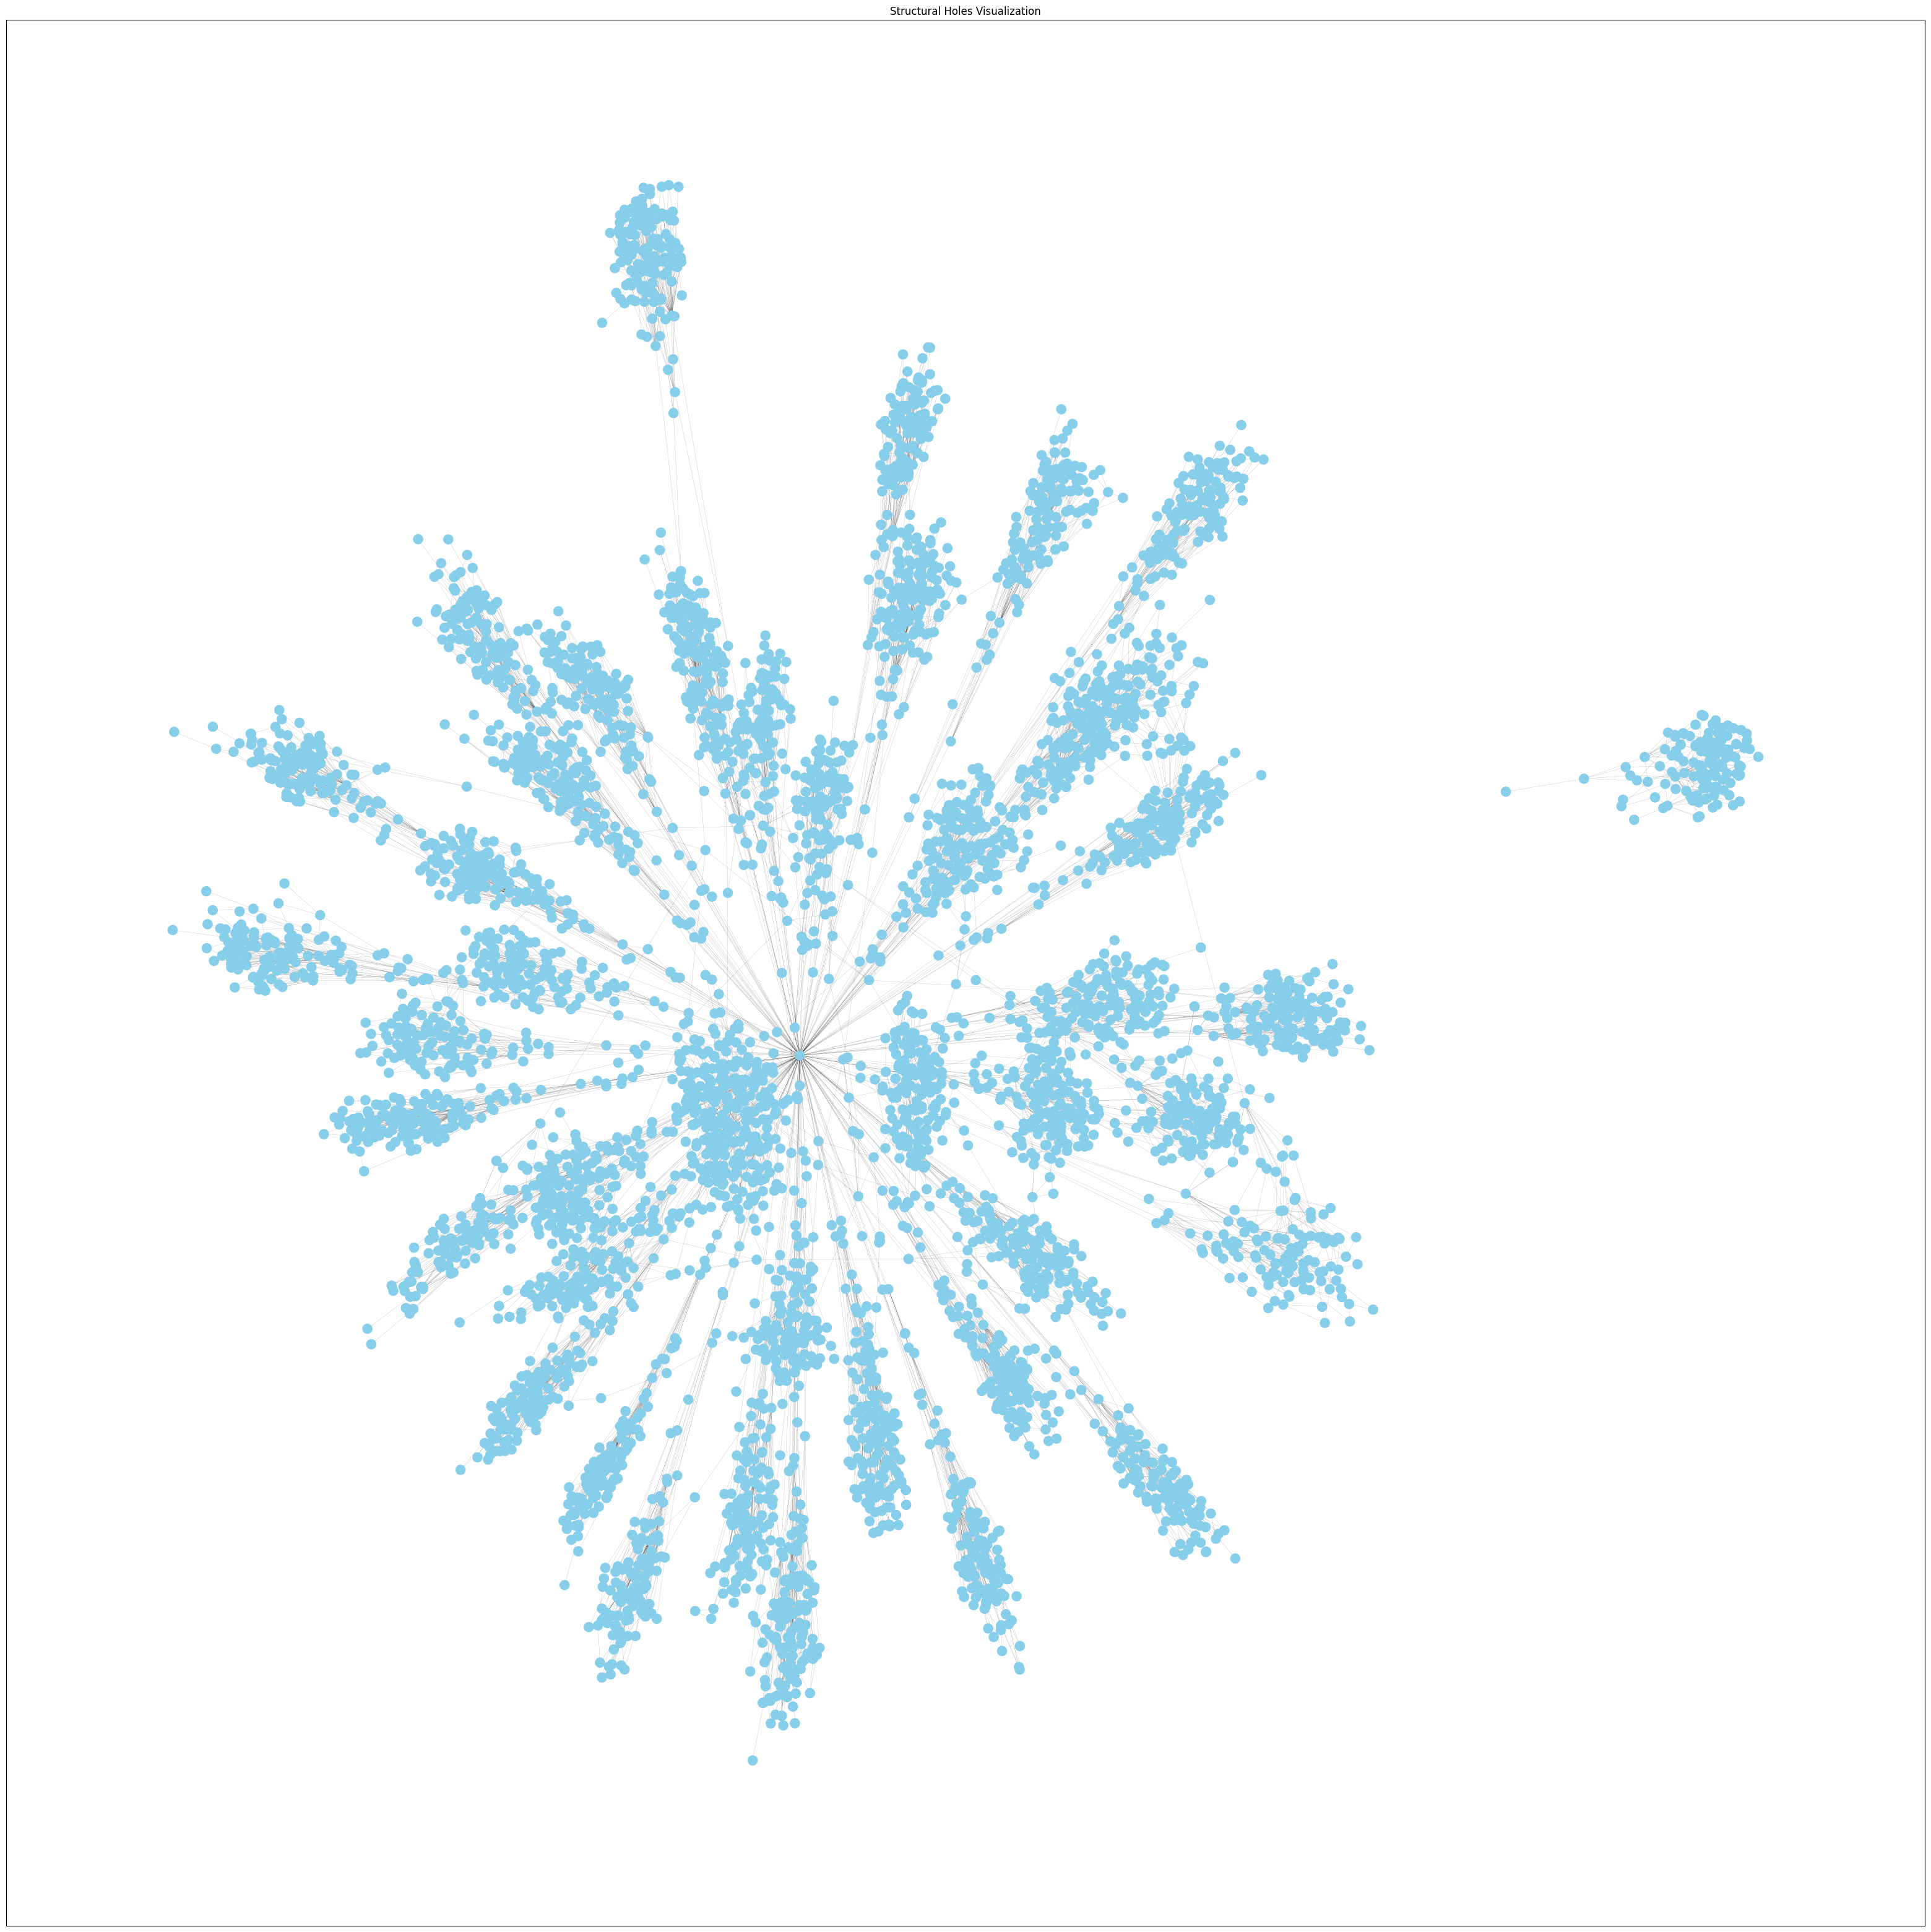

In [68]:
fig = plt.subplots(figsize=(40, 40))
#nx.draw(G_sampled, pos, with_labels=False, node_size=0.02, width=0.05, node_color=holes_values, cmap=plt.cm.RdYlBu)
nx.draw_networkx_nodes(G_sampled, pos, node_size=[v * 0.02 for v in holes.values()], node_color='skyblue')
nx.draw_networkx_edges(G_sampled, pos, width=0.1, alpha=0.7)
# Add colorbar
#fig.colorbar(mappable, ax=ax, label='Structural Holes Score')
plt.title('Structural Holes Visualization')
plt.show()

In [14]:
#print(holes_values)